# Beginners Guide to `caskade`

Here we will introduce all of the relevant concepts and capabilities of `caskade` and how to build numerical simulators.

In [1]:
from caskade import Module, Param, forward
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from time import time

## Basic Template

All `caskade` simulators follow the same basic template. Certain ingredients are always involved:

- Subclass the `Module` object
- Call the `super().__init__()` at the top
- Create some `Param` attributes
- Decorate a function with `@forward`
- Include some of the params (by attribute name) as keyword arguments

You can also provide a name for the `Module`, though this is optional.

In [2]:
class Gaussian(Module):
    def __init__(self, name, x0=None, q=None, phi=None, sigma=None, I0=None):
        super().__init__(name)
        self.x0 = Param("x0", x0, shape=(2,)) # position
        self.q = Param("q", q) # axis ratio
        self.phi = Param("phi", phi) # orientation
        self.sigma = Param("sigma", sigma) # width
        self.I0 = Param("I0", I0) # intensity

    @forward
    def _r(self, x, y, x0=None, q=None, phi=None):
        x, y = x - x0[...,0], y - x0[...,1]
        s, c = torch.sin(phi), torch.cos(phi)
        x, y = c * x - s * y, s * x + c * y
        return (x ** 2 + (y * q) ** 2).sqrt()
    
    @forward
    def brightness(self, x, y, sigma=None, I0=None):
        return I0 * (-self._r(x, y)**2 / sigma**2).exp()

We may now create instances of this simulator, and inspect what the compute graph looks like.

my first module|module
    x0|dynamic
    q|dynamic
    phi|dynamic
    sigma|static
    I0|static


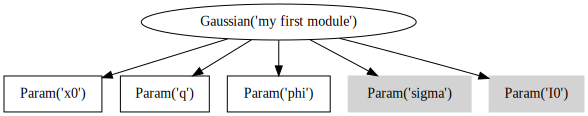

In [3]:
firstsim = Gaussian("my first module", sigma = 0.2, I0 = 1.0)
print(firstsim) # print the graph
firstsim.graphviz() # show the graph

Finally, we can build our list of parameters which will be in the same order (only dynamic ones) that they are printed.

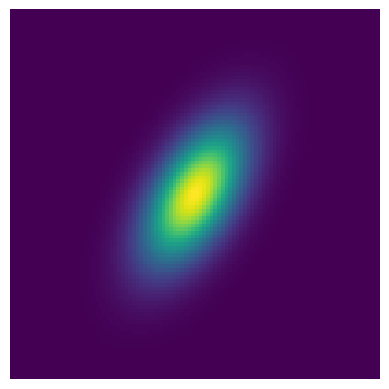

In [4]:
x, y = torch.meshgrid(torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100), indexing="ij")
#                       x0                       q                  phi
params = [torch.tensor((0.0, 0.0)), torch.tensor(0.5), torch.tensor(3.14 / 3)]
plt.imshow(firstsim.brightness(x, y, params), origin="lower")
plt.axis("off")
plt.show()

## Different ways to pass the parameters

W can pass the parameters into a `caskade` forward method as one of a `list`, a 1D `Tensor`, or a `dict`. 

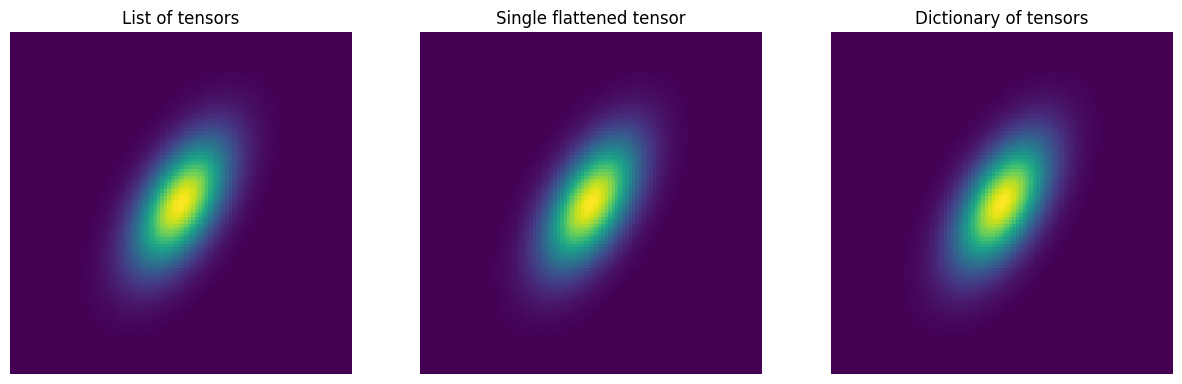

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# List of tensors (this is what we did above)
params_list = [torch.tensor((0.0, 0.0)), torch.tensor(0.5), torch.tensor(3.14 / 3)]
ax[0].imshow(firstsim.brightness(x, y, params_list), origin="lower")
ax[0].axis("off")
ax[0].set_title("List of tensors")

# Single flattened tensor
params_tensor = torch.cat([p.flatten() for p in params_list])
ax[1].imshow(firstsim.brightness(x, y, params_tensor), origin="lower")
ax[1].axis("off")
ax[1].set_title("Single flattened tensor")

# Dictionary of tensors, using attribute names of either Param or Module objects
params_dict = {"x0": torch.tensor((0.0, 0.0)), "q": torch.tensor(0.5), "phi": torch.tensor(3.14 / 3)}
ax[2].imshow(firstsim.brightness(x, y, params_dict), origin="lower")
ax[2].axis("off")
ax[2].set_title("Dictionary of tensors")
plt.show()

Next, once we have the `params` we can either pass it as the last positional argument, as a `params=` keyword, or we can set them as `static`.

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Pass as last positional argument
ax[0].imshow(firstsim.brightness(x, y, params_list), origin="lower")

# Pass as keyword argument
ax[1].imshow(firstsim.brightness(x, y, params=params_list), origin="lower")

# Set parameters as static
firstsim.x0 = params_dict["x0"]
firstsim.q = params_dict["q"]
firstsim.phi = params_dict["phi"]
ax[2].imshow(firstsim.brightness(x, y), origin="lower")
# Set them back to dynamic
firstsim.x0 = None
firstsim.q = None
firstsim.phi = None
plt.close(fig)

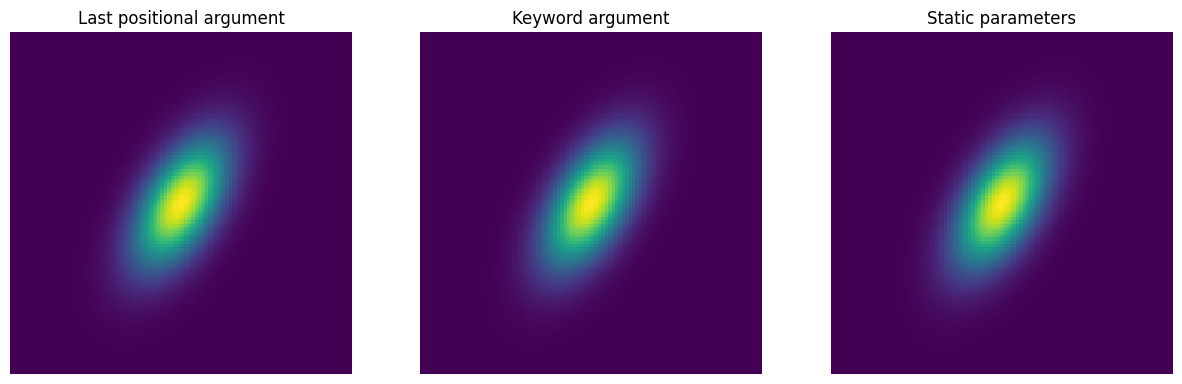

In [7]:
ax[0].axis("off")
ax[0].set_title("Last positional argument")
ax[1].axis("off")
ax[1].set_title("Keyword argument")
ax[2].axis("off")
ax[2].set_title("Static parameters")
fig

## The `pointer` parameter

So far we have only looked at `dynamic` and `static` parameters. `caskade` allows users to build complex simulators with relationships between parameters. Next lets see the `pointer` type: 

- `dynamic` is given as input when calling a `@forward` method
- `static` is a fixed value
- `pointer` returns the value computed from other nodes in the graph

In [8]:
secondsim = Gaussian("my second module", phi = 3.14*5/6, q = 0.2, sigma = 0.2, I0 = 0.5)
secondsim.x0 = firstsim.x0 # now they share the same position

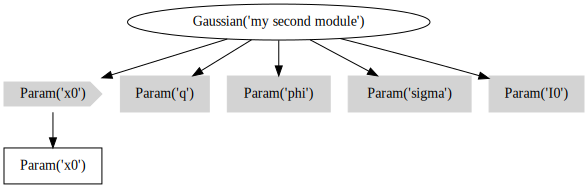

In [9]:
secondsim.graphviz()

As you can see, a `pointer` parameter is represented in the graph as a shaded arrow. It will now return the same value as the `x0` parameter in `firstsim`.

## Nested Modules

The real power of `caskade` comes from nesting `Module` objects to build complex scientific simulators, all while keeping the flexible and robust interfaces seen above.

In [10]:
class Combined(Module):
    def __init__(self, name, first, second):
        super().__init__(name)
        self.first = first # Modules are automatically registered
        self.second = second

    @forward
    def brightness(self, x, y):
        return self.first.brightness(x, y) + self.second.brightness(x, y)

my combined module|module
    my first module|module
        x0|dynamic
        q|dynamic
        phi|dynamic
        sigma|static
        I0|static
    my second module|module
        x0|pointer
            x0|dynamic
        q|static
        phi|static
        sigma|static
        I0|static


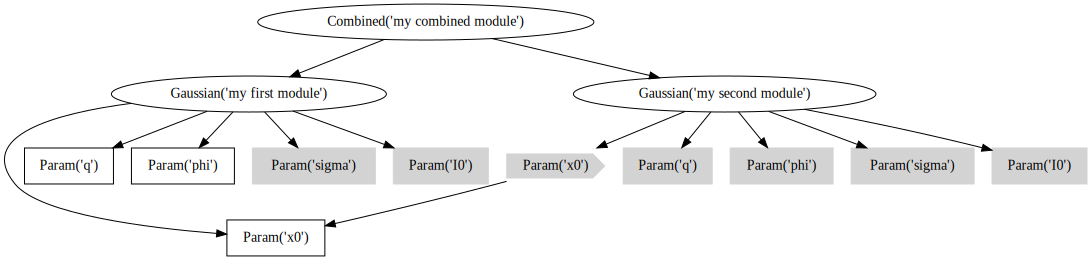

In [11]:
combinedsim = Combined("my combined module", firstsim, secondsim)
print(combinedsim)
combinedsim.graphviz()

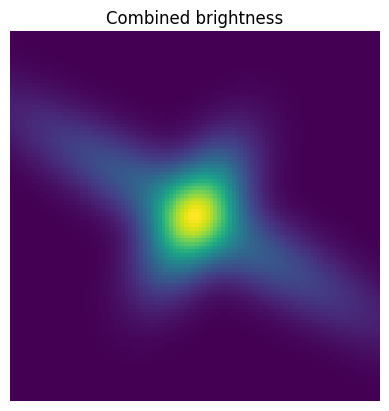

In [12]:
# same params as before since secondsim is all static or pointers to firstsim
plt.imshow(combinedsim.brightness(x, y, params_list), origin="lower")
plt.axis("off")
plt.title("Combined brightness")
plt.show()

## Functional `pointer`s

A `pointer` parameter determines it's value from other parameters. This can go beyond just returning the same value. One can define an arbitrary function.

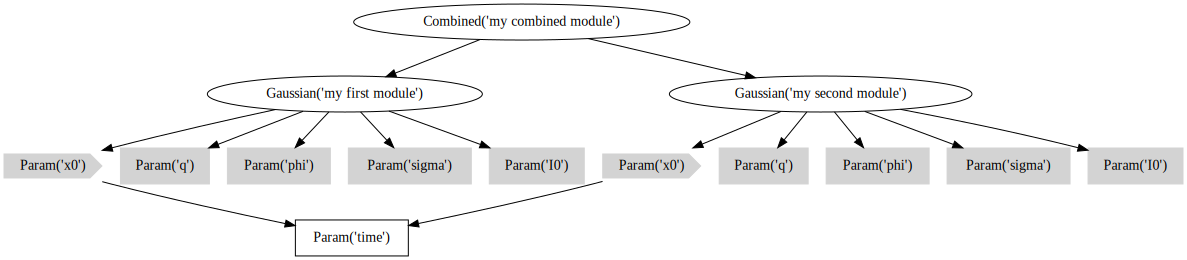

In [13]:
simtime = Param("time") # create a parameter for time
firstsim.x0 = lambda p: (-p["time"].value +0.5)*torch.tensor((1,-1))
firstsim.x0.link(simtime)
secondsim.x0 = lambda p: p["time"].value*torch.tensor((1,1)) - 0.5
secondsim.x0.link(simtime)

firstsim.q = 0.5
firstsim.phi = 3.14 / 3

combinedsim.graphviz()

In [14]:
B = 64
fig, ax = plt.subplots()
img = ax.imshow(combinedsim.brightness(x, y, torch.tensor([0.0])), origin="lower", vmin=0, vmax=1.5)
ax.set_title("Brightness at time 0")

def update(i):
    img.set_data(combinedsim.brightness(x, y, torch.tensor([i / B])))
    ax.set_title(f"Brightness at time {i / B:.2f}")
    return img

ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

# Or display the animation inline
HTML(ani.to_jshtml())

## Interacting with PyTorch

The above animation was made with a `for-loop`, but using the `PyTorch` `vmap` function we can produce the frames a lot faster. In this case, `vmap` is up to 5x faster than the `for-loop` but with lots of fluctuations.

In [15]:
batched_params_tensor = torch.linspace(0, 1, 64).reshape(64, 1) # only 1 param "time" so last dim is 1

start = time()
result = []
for i in range(B):
    result.append(combinedsim.brightness(x, y, batched_params_tensor[i]))
result = torch.stack(result)
print("for-loop time taken: ", time() - start)

vbrightness = torch.vmap(combinedsim.brightness, in_dims=(None, None, 0))
start = time()
result = vbrightness(x, y, batched_params_tensor)
print("vmap time taken: ", time() - start)

for-loop time taken:  0.3419454097747803
vmap time taken:  0.0344240665435791


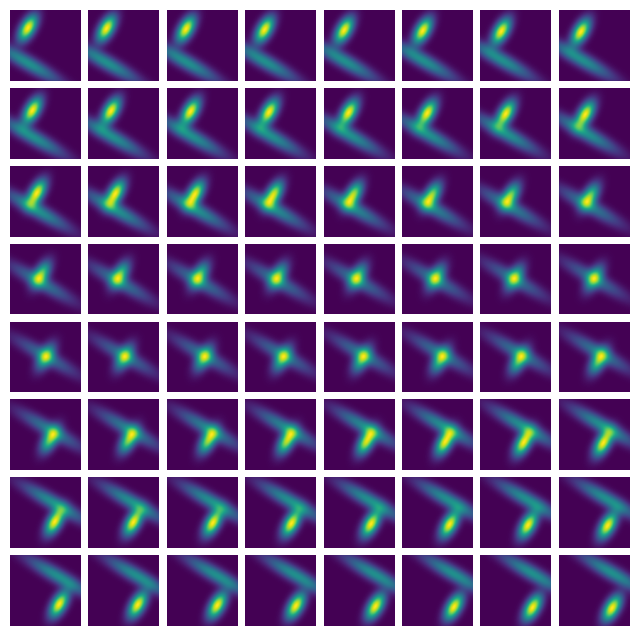

In [16]:
fig, axarr = plt.subplots(8, 8, figsize=(8, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, ax in enumerate(axarr.flat):
    ax.imshow(result[i], origin="lower")
    ax.axis("off")
plt.show()

Note that it is also possible for `Module` objects to accept batched parameters. However, keep in mind that this simply means passing through the parameters normally, except with extra dimensions. You can/will get different behavior than vmap, which is closer to treating the batch dimension as a `for-loop`. This may actually be the desired effect, it's up to you to build the simulator accordingly.

Direct batching typically a bit faster than `vmap`, but minor fluctuations dominate in this demo so we can't really see it.

In [17]:
# Batched by the parameters, instead of using vmap to make the simulations
batched_params_tensor = torch.linspace(0, 1, 64).reshape(64, 1, 1, 1, 1) # dims: (64 time steps, 1 img h, 1 img w, 1 xy pos, 1 param)
start = time()
result = combinedsim.brightness(x, y, batched_params_tensor)
print("batched time taken: ", time() - start)

batched time taken:  0.03307318687438965


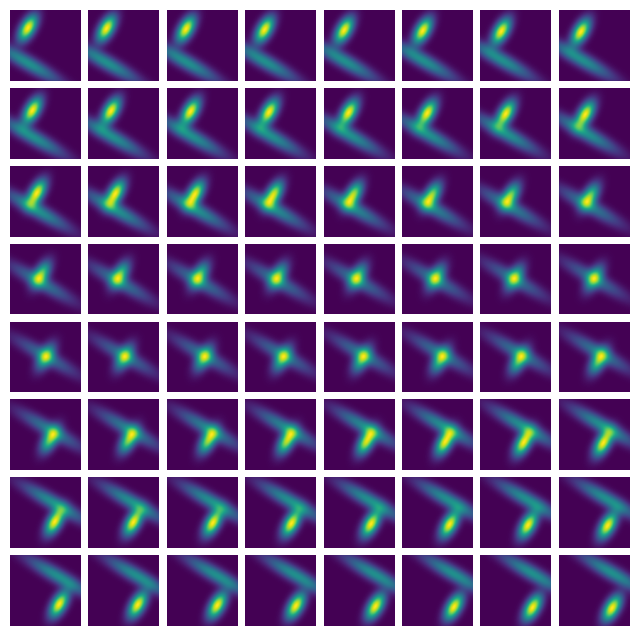

In [18]:
fig, axarr = plt.subplots(8, 8, figsize=(8, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, ax in enumerate(axarr.flat):
    ax.imshow(result[i], origin="lower")
    ax.axis("off")
plt.show()

We can also use `PyTorch` autograd functionalities on `caskade` simulators. All of the `PyTorch` calculus operations will work on `caskade` simulators, so one may compute a likelihood and perform gradient descent very easily, to name one example.

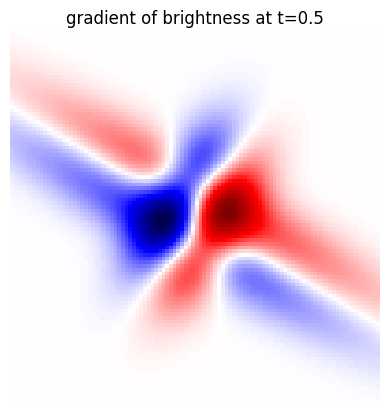

In [19]:
# using PyTorch autograd
params_tensor = torch.tensor([0.5])
plt.imshow(torch.func.jacfwd(combinedsim.brightness,argnums=2)(x, y, params_tensor), origin="lower", cmap="seismic")
plt.axis("off")
plt.title("gradient of brightness at t=0.5")
plt.show()

And we're done! Those are all the elemental abilities of `caskade`, I hope that by this point you have a sense of the vast possibilities of simulators that can be constructed. Happy science-ing!